<div class="alert alert-block alert-info">
<h2>Import packages:</h2>
</div>

In [1]:
import pandas as pd
import datetime as dt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'svg'

---

<div class="alert alert-block alert-info">
<h2>Import Data & Explore:</h2>
</div>

In [2]:
retail_df = pd.read_excel('/Users/walter/Desktop/REPOS/analytics-stories/Cohort-Analysis-Retail/data/Online_Retail.xlsx')
retail_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


### Get the percent of null datapoints per column:

In [3]:
pd.DataFrame(retail_df.isnull().mean().round(4)*100, columns=['Percent Null'])

,Percent Null
InvoiceNo,0.00
StockCode,0.00
Description,0.27
Quantity,0.00
InvoiceDate,0.00
UnitPrice,0.00
CustomerID,24.93
Country,0.00


<div class="alert alert-block alert-warning">
<b>Note:</b> Approximately 25% of the data is missing for the custome IDs. We will have to drop these.
</div>

In [4]:
retail_df = retail_df.dropna(subset=['CustomerID'])
pd.DataFrame(retail_df.isnull().mean().round(4)*100, columns=['Percent Null'])

,Percent Null
InvoiceNo,0.0
StockCode,0.0
Description,0.0
Quantity,0.0
InvoiceDate,0.0
UnitPrice,0.0
CustomerID,0.0
Country,0.0


<div class="alert alert-block alert-success">
<b>Note:</b> now we have no missing records.
</div>

---

<div class="alert alert-block alert-info">
<h2>Prepare Data for Cohort Analysis:</h2>
</div>

### Fist we build a function to handle the date formats:
Convert the date column into a `datetime object` and then extract month and year.

In [5]:
def date_handler(df, col):
    # Operate on a copy to avoid SettingWithCopyWarning:
    transformed_df = df.copy()
    
    # Convert the date column to datetime and create new columns:
    transformed_df[col] = pd.to_datetime(transformed_df[col])
    
    # Group by CustomerID and get the first purchase date:
    first_purchase_df = transformed_df.groupby('CustomerID')[col].min().reset_index()
    first_purchase_df.rename(columns={col: 'FirstPurchaseDate'}, inplace=True)
    
    # Merge to get the 'FirstPurchase' column in the main dataframe:
    transformed_df = transformed_df.merge(first_purchase_df, how='left', on='CustomerID')

    # Ensure that the 'FirstPurchaseDate' is a datetime object as well:
    transformed_df['FirstPurchaseDate'] = pd.to_datetime(transformed_df['FirstPurchaseDate'])

    # Get the number of months the user is active by subtracting the invoice date from the 1st purchase date.
    # Ensure 'FirstPurchaseDate' is earlier than 'InvoiceDate' before subtracting to get 'MonthsActive':
    transformed_df['MonthsActive'] = (
        (transformed_df['InvoiceDate'].dt.year - transformed_df['FirstPurchaseDate'].dt.year) * 12
        + (transformed_df['InvoiceDate'].dt.month - transformed_df['FirstPurchaseDate'].dt.month) + 1
    )

    # # If the day of 'InvoiceDate' is earlier than the day of 'FirstPurchaseDate', subtract one month:
    # mask = transformed_df['InvoiceDate'].dt.day < transformed_df['FirstPurchaseDate'].dt.day
    # transformed_df.loc[mask, 'MonthsActive'] -= 1

    # # Ensure 'MonthsActive' is not negative (do zero if so)
    # transformed_df['MonthsActive'] = transformed_df['MonthsActive'].clip(lower=0)

    # Create Cohort Month column:
    transformed_df['CohortMonth'] = (transformed_df['FirstPurchaseDate'].dt.year.astype(str)
                                    + '-' + transformed_df['FirstPurchaseDate'].dt.month.astype(str).str.zfill(2))

    return transformed_df


In [6]:
retail_df = date_handler(retail_df, 'InvoiceDate')
retail_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,FirstPurchaseDate,MonthsActive,CohortMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01 08:26:00,1,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,1,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01 08:26:00,1,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,1,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,1,2010-12
...,...,...,...,...,...,...,...,...,...,...,...
406824,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,2011-08-18 15:44:00,5,2011-08
406825,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,2011-08-18 15:44:00,5,2011-08
406826,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-08-18 15:44:00,5,2011-08
406827,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-08-18 15:44:00,5,2011-08


---

<div class="alert alert-block alert-info">
<h2>Create Cohort table:</h2>
</div>

### First group by CohortMonth and #of months active to get the count of unique customers for that cohort month and active month combination:

In [7]:
cohort_df = retail_df.groupby(['CohortMonth', 'MonthsActive'])['CustomerID'].nunique().reset_index().rename(columns={'CustomerID': 'UniqueCustomers'})
cohort_df

,CohortMonth,MonthsActive,UniqueCustomers
0,2010-12,1,948
1,2010-12,2,362
2,2010-12,3,317
3,2010-12,4,367
4,2010-12,5,341
...,...,...,...
86,2011-10,2,93
87,2011-10,3,46
88,2011-11,1,321
89,2011-11,2,43


### Create a cohort table by pivoting on the grouped dataframe from the previous step:

In [8]:
cohort_table = pd.pivot_table(data=cohort_df, columns='MonthsActive', index='CohortMonth', values='UniqueCustomers')
cohort_table.fillna('')

MonthsActive,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12,948.0,362.0,317.0,367.0,341.0,376.0,360.0,336.0,336.0,374.0,354.0,474.0,260.0
2011-01,421.0,101.0,119.0,102.0,138.0,126.0,110.0,108.0,131.0,146.0,155.0,63.0,
2011-02,380.0,94.0,73.0,106.0,102.0,94.0,97.0,107.0,98.0,119.0,35.0,,
2011-03,440.0,84.0,112.0,96.0,102.0,78.0,116.0,105.0,127.0,39.0,,,
2011-04,299.0,68.0,66.0,63.0,62.0,71.0,69.0,78.0,25.0,,,,
2011-05,279.0,66.0,48.0,48.0,60.0,68.0,74.0,29.0,,,,,
2011-06,235.0,49.0,44.0,64.0,58.0,79.0,24.0,,,,,,
2011-07,191.0,40.0,39.0,44.0,52.0,22.0,,,,,,,
2011-08,167.0,42.0,42.0,42.0,23.0,,,,,,,,


### We can get the percent of each cohort that remains per active month:

In [9]:
cohort_table_percent = (cohort_table.divide(cohort_table.iloc[:, 0], axis=0)*100).round()
cohort_table_percent.fillna('')

MonthsActive,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12,100.0,38.0,33.0,39.0,36.0,40.0,38.0,35.0,35.0,39.0,37.0,50.0,27.0
2011-01,100.0,24.0,28.0,24.0,33.0,30.0,26.0,26.0,31.0,35.0,37.0,15.0,
2011-02,100.0,25.0,19.0,28.0,27.0,25.0,26.0,28.0,26.0,31.0,9.0,,
2011-03,100.0,19.0,25.0,22.0,23.0,18.0,26.0,24.0,29.0,9.0,,,
2011-04,100.0,23.0,22.0,21.0,21.0,24.0,23.0,26.0,8.0,,,,
2011-05,100.0,24.0,17.0,17.0,22.0,24.0,27.0,10.0,,,,,
2011-06,100.0,21.0,19.0,27.0,25.0,34.0,10.0,,,,,,
2011-07,100.0,21.0,20.0,23.0,27.0,12.0,,,,,,,
2011-08,100.0,25.0,25.0,25.0,14.0,,,,,,,,


---

<div class="alert alert-block alert-info">
<h2>Visualize Cohort table:</h2>
</div>

### Create a function to plot the cohort table:

In [10]:
def plot_cohort_table(df, heat_legend, colormap):
    # Convert the percentage values to a formatted string
    text_values = df.map('{:.2f}%'.format)
    
    # Create the heatmap with Plotly Express and display cell values
    fig = px.imshow(
        df,
        labels=dict(x="Months Active", y="Cohort Month", color=heat_legend),
        x=df.columns,
        y=df.index,
        text_auto=True,  # You can set this to False if you're providing z_text
        # If you want specific formatting or to use the text_values from above, comment out text_auto and use:
        # z_text=text_values.values,
        color_continuous_scale=colormap
    )
    
    # Update the layout
    fig.update_layout(
        title='Cohort Analysis',
        xaxis=dict(side="bottom", tickvals=df.columns),
        yaxis=dict(tickvals=df.index),
        height=800
    )
    
    # Show the figure
    return fig.show(width=1600)
    

### Plot:

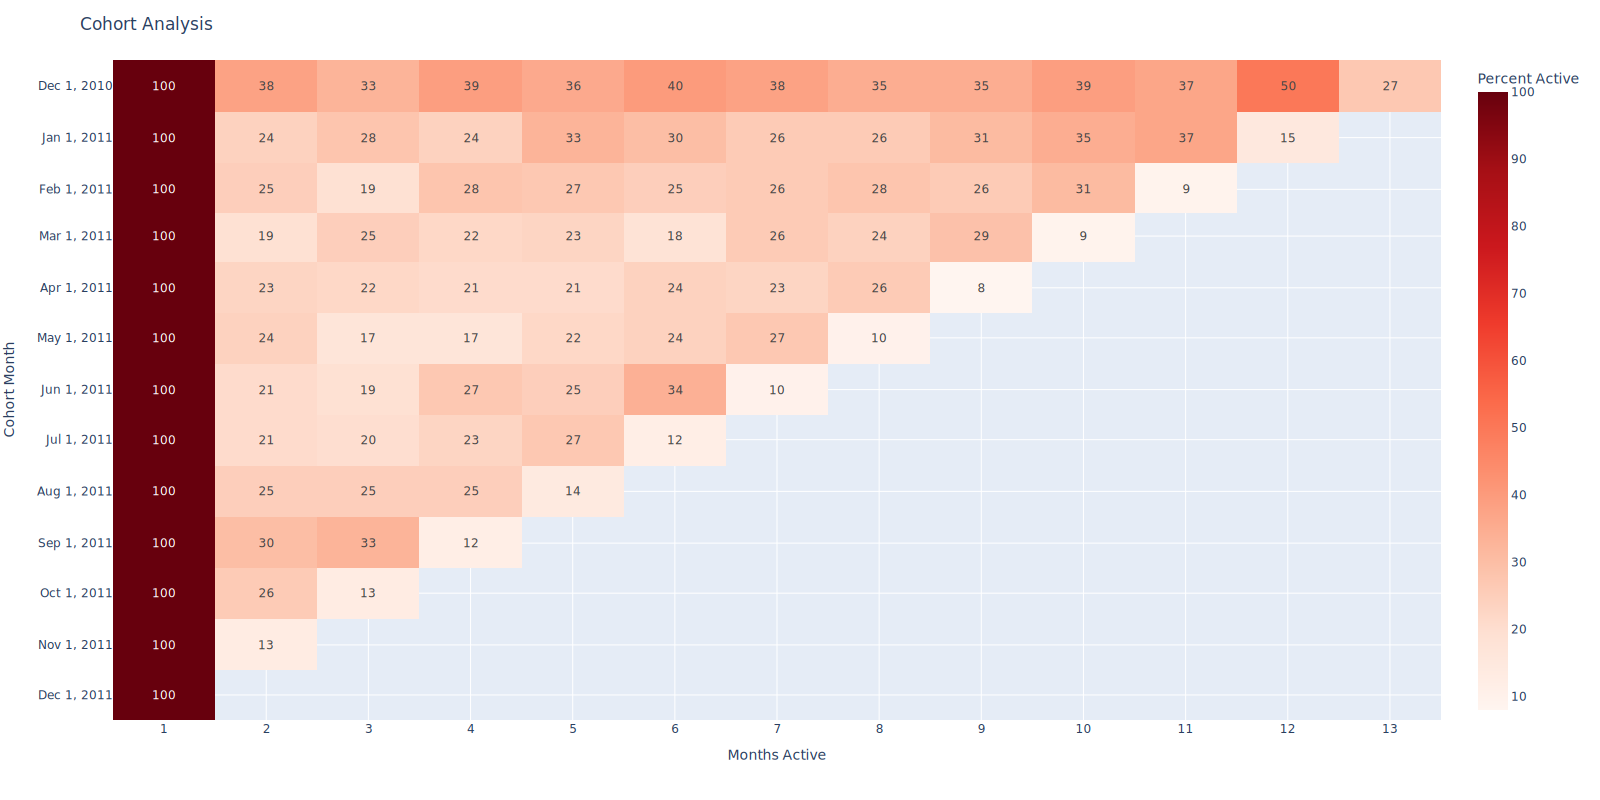

In [11]:
plot_cohort_table(cohort_table_percent, 'Percent Active', 'Reds')

---

<div class="alert alert-block alert-info">
<h2>Let's create a similar table but we are going to look at the cohort LTV this time:</h2>
</div>

### Begin with the preprocessed retail_df and go from there:

In [12]:
retail_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,FirstPurchaseDate,MonthsActive,CohortMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01 08:26:00,1,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,1,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01 08:26:00,1,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,1,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,1,2010-12
...,...,...,...,...,...,...,...,...,...,...,...
406824,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,2011-08-18 15:44:00,5,2011-08
406825,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,2011-08-18 15:44:00,5,2011-08
406826,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-08-18 15:44:00,5,2011-08
406827,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-08-18 15:44:00,5,2011-08


### Calculate the order total from unit price and quantity:

In [13]:
retail_df['OrderTotal'] = retail_df['UnitPrice']*retail_df['Quantity']
retail_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,FirstPurchaseDate,MonthsActive,CohortMonth,OrderTotal
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01 08:26:00,1,2010-12,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,1,2010-12,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01 08:26:00,1,2010-12,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,1,2010-12,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,1,2010-12,20.34
...,...,...,...,...,...,...,...,...,...,...,...,...
406824,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,2011-08-18 15:44:00,5,2011-08,10.20
406825,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,2011-08-18 15:44:00,5,2011-08,12.60
406826,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-08-18 15:44:00,5,2011-08,16.60
406827,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-08-18 15:44:00,5,2011-08,16.60


### First group by CohortMonth and #of months active to get the sum of OrderTotal for that cohort month and active month combination:

In [14]:
cohort_ltv_df = retail_df.groupby(['CohortMonth', 'MonthsActive']).agg(
    TotalOrderValue=('OrderTotal', 'sum'),
    UniqueCustomers=('CustomerID', 'nunique')).reset_index()
cohort_ltv_df

,CohortMonth,MonthsActive,TotalOrderValue,UniqueCustomers
0,2010-12,1,554604.02,948
1,2010-12,2,271616.52,362
2,2010-12,3,230856.22,317
3,2010-12,4,302509.39,367
4,2010-12,5,200927.98,341
...,...,...,...,...
86,2011-10,2,39209.92,93
87,2011-10,3,12279.46,46
88,2011-11,1,134231.38,321
89,2011-11,2,14847.53,43


### Get the average order value per customer for each of the cohort months and months active:

In [15]:
cohort_ltv_df['AvgCohortOrderValue'] = (cohort_ltv_df['TotalOrderValue']/cohort_ltv_df['UniqueCustomers']).round(2)
cohort_ltv_df

,CohortMonth,MonthsActive,TotalOrderValue,UniqueCustomers,AvgCohortOrderValue
0,2010-12,1,554604.02,948,585.03
1,2010-12,2,271616.52,362,750.32
2,2010-12,3,230856.22,317,728.25
3,2010-12,4,302509.39,367,824.28
4,2010-12,5,200927.98,341,589.23
...,...,...,...,...,...
86,2011-10,2,39209.92,93,421.61
87,2011-10,3,12279.46,46,266.94
88,2011-11,1,134231.38,321,418.17
89,2011-11,2,14847.53,43,345.29


<div class="alert alert-block alert-info">
<h2>Build Cohort LTV table:</h2>
</div>

### Create a pivot table:

In [16]:
cohort_ltv_table = pd.pivot_table(data=cohort_ltv_df, columns='MonthsActive', index='CohortMonth', values='AvgCohortOrderValue')
cohort_ltv_table.fillna('')

MonthsActive,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12,585.03,750.32,728.25,824.28,589.23,855.35,869.15,904.49,925.25,1247.54,1239.65,1078.02,703.13
2011-01,483.27,556.12,523.23,407.02,596.47,666.74,638.35,674.87,568.17,713.57,787.27,442.07,
2011-02,393.48,268.73,513.1,432.57,349.67,330.66,491.4,521.87,529.2,508.78,267.62,,
2011-03,431.66,314.09,479.41,420.04,458.43,491.8,522.61,587.67,514.2,288.52,,,
2011-04,400.55,425.31,377.7,379.24,419.46,417.65,409.04,434.48,251.68,,,,
2011-05,415.26,267.64,393.26,372.69,443.19,484.58,424.35,366.52,,,,,
2011-06,393.73,277.95,315.76,467.58,445.44,503.35,330.23,,,,,,
2011-07,344.94,278.16,394.76,391.42,371.71,275.28,,,,,,,
2011-08,465.02,455.3,787.18,950.6,614.92,,,,,,,,


### Plot to see avg. order for each cohort and month active combination:

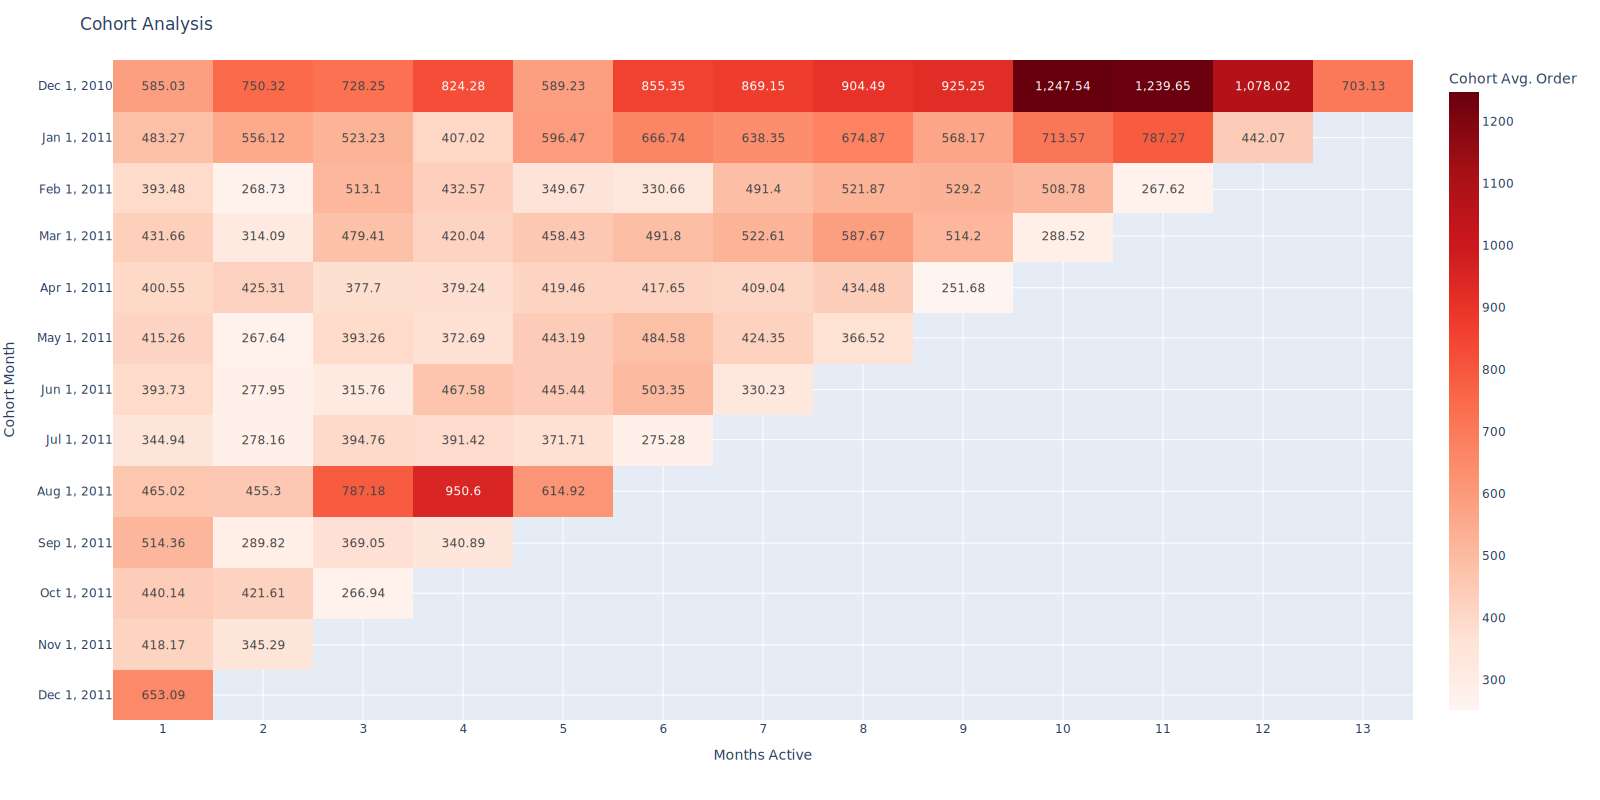

In [17]:
plot_cohort_table(cohort_ltv_table, 'Cohort Avg. Order', 'Reds')

### Get the cumulative sum for each cohort month and months active:

In [18]:
cohort_ltv_cumulative = cohort_ltv_table.cumsum(axis=1)
cohort_ltv_cumulative.fillna('')

MonthsActive,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12,585.03,1335.35,2063.6,2887.88,3477.11,4332.46,5201.61,6106.1,7031.35,8278.89,9518.54,10596.56,11299.69
2011-01,483.27,1039.39,1562.62,1969.64,2566.11,3232.85,3871.2,4546.07,5114.24,5827.81,6615.08,7057.15,
2011-02,393.48,662.21,1175.31,1607.88,1957.55,2288.21,2779.61,3301.48,3830.68,4339.46,4607.08,,
2011-03,431.66,745.75,1225.16,1645.2,2103.63,2595.43,3118.04,3705.71,4219.91,4508.43,,,
2011-04,400.55,825.86,1203.56,1582.8,2002.26,2419.91,2828.95,3263.43,3515.11,,,,
2011-05,415.26,682.9,1076.16,1448.85,1892.04,2376.62,2800.97,3167.49,,,,,
2011-06,393.73,671.68,987.44,1455.02,1900.46,2403.81,2734.04,,,,,,
2011-07,344.94,623.1,1017.86,1409.28,1780.99,2056.27,,,,,,,
2011-08,465.02,920.32,1707.5,2658.1,3273.02,,,,,,,,


### Plot cumulative sum table to get the LTV of each cohort and months active combination:

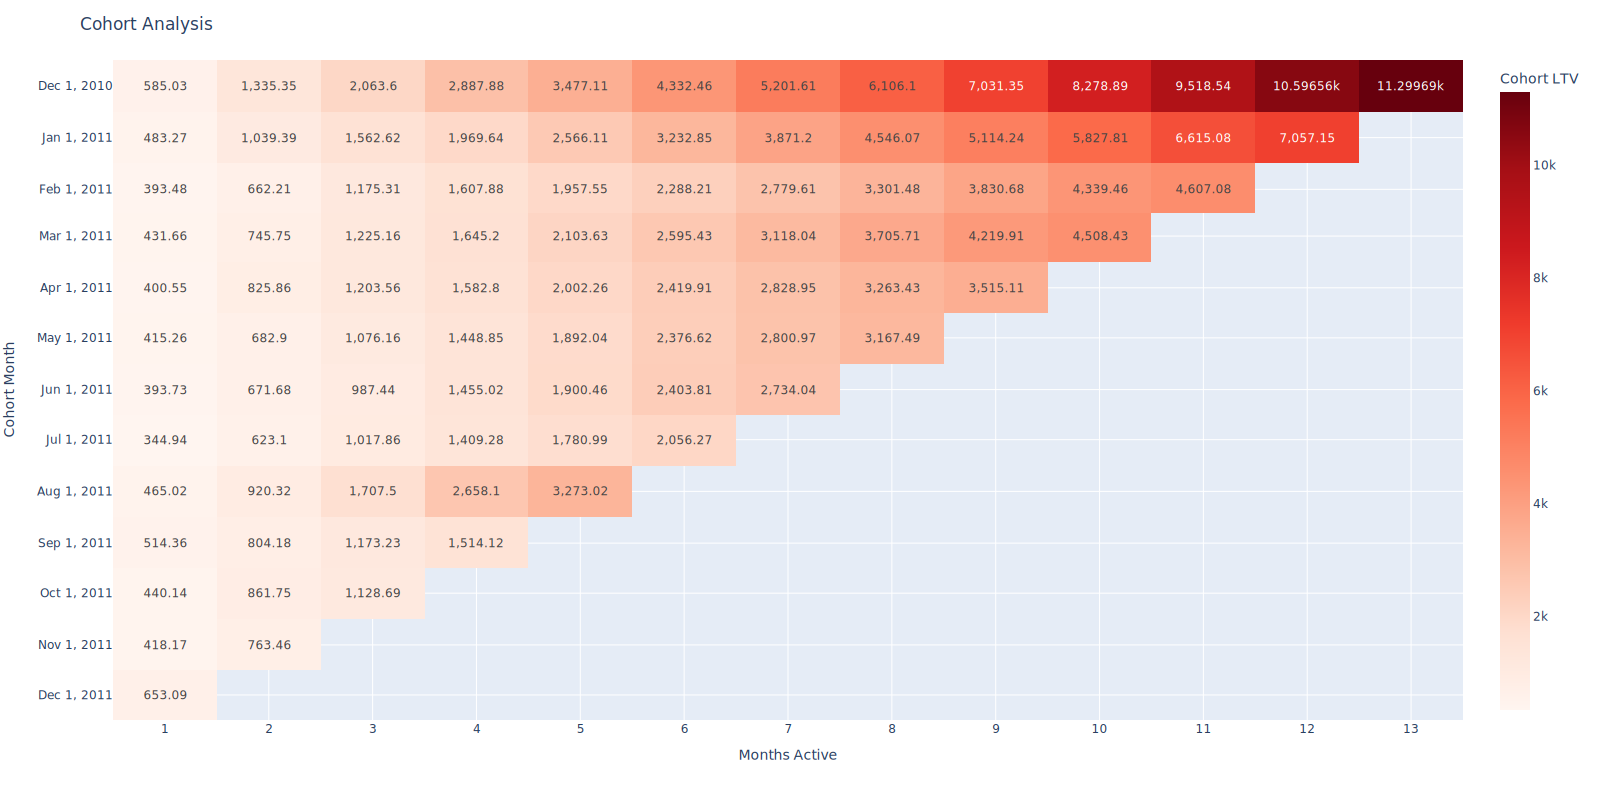

In [19]:
plot_cohort_table(cohort_ltv_cumulative, 'Cohort LTV', 'Reds')